In [1]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [2]:
import subprocess
from transformers import AutoModel, pipeline, Trainer, AutoTokenizer
import json
from datasets import Dataset, load_dataset, concatenate_datasets
import evaluate
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

c:\GitHub\PRPR\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [4]:
sampling_strategy = 1.0
rsmpl = RandomUnderSampler(sampling_strategy=sampling_strategy)

In [ ]:

from tree_sitter import Language, Parser


CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')

parser = Parser()
parser.set_language(CPP_LANGUAGE)

In [5]:
def get_index_code_dict(emb_ds):
    res_dict = {}
    
    for el in emb_ds:
        res_dict[el["index"]] = el["embedding"]
        
    return res_dict
    

In [6]:
#эмбеддинги для батча
def get_embeddings(inputs, model):
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings

In [7]:
def get_pairs_ds(emb_ds):
    id = 0
    print(len(emb_ds))
    id_1 = []
    id_2 = []
    is_same = []
    same_class = []
    for i in range(len(emb_ds)-1):
        id += 1
        if id % 100 == 0 or id == 10:
            print(id)
        for j in range(i+1, len(emb_ds)):
            id_1.append(i)
            id_2.append(j)
            are_same = emb_ds[i]["label"] == emb_ds[j]["label"]
            is_same.append(int(are_same))
            if are_same:
                same_class.append(emb_ds[i]["label"])
            else:
                same_class.append(-100)

    dataset = Dataset.from_dict({ "id_1":id_1,"id_2": id_2,
                                    "is_same": is_same, "same_class": same_class})
    return dataset

In [15]:
        
def get_similarities_ds(emb_ds, resampled_ds):
    X = []
    y = []
    for el in resampled_ds:
        conc_tensor = torch.cat([
            torch.Tensor(emb_ds[el["id_1"]]["embeddings"]),
            torch.Tensor(emb_ds[el["id_2"]]["embeddings"]),
            torch.Tensor(pairwise_distances(emb_ds[el["id_1"]]["embeddings"],emb_ds[el["id_2"]]["embeddings"],
                                                   metric='cosine'))
        ], dim=1)
        X.append(conc_tensor.view(-1))
        y.append(el["is_same"])
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.3, stratify=y, random_state=49)
    
    X_eval, X_test, y_eval, y_test = train_test_split(X_t, y_t, test_size=0.7, random_state=64)
    return X_train, X_eval, X_test, y_train, y_eval, y_test
        

In [9]:
def get_accuracy(emb_dataset):
    index_1 = []
    index_2 = []
    code_1 = []
    code_2 = []
    is_clones = []
    similarities = []
    for i in range(len(emb_dataset) - 1):
        i_label = emb_dataset[i]["label"]
        i_embeddings = torch.Tensor(emb_dataset[i]["embedding"][0]).reshape([1, -1])
        
        if i % 10 == 0:
            print(i)
            
        for j in range(i+1, len(emb_dataset)):
            j_label = emb_dataset[j]["label"]
            j_embeddings = torch.Tensor(emb_dataset[j]["embedding"][0]).reshape([1, -1])
            
            similarity = pairwise_distances(i_embeddings,j_embeddings,
                                                   metric='manhattan')
            
            index_1.append(emb_dataset[i]["index"])
            index_2.append(emb_dataset[j]["index"])
            code_1.append(emb_dataset[i]["res_code"])
            code_2.append(emb_dataset[j]["res_code"])
            is_clones.append(int(emb_dataset[i]["label"] == emb_dataset[j]["label"]))
            similarities.append(similarity)
            
    acc_dataset = Dataset.from_dict({ "index_1":index_1,"index_2": index_2, "is_clones": is_clones,
                                "similarities": similarities})
    return acc_dataset
    

In [10]:


def get_tokenized_dataset_orig(datafile, model):
    index = []
    label = []
    code = []
    code_1 = []
    code_2 = []
    bin_labels = []

    input_ids_1 = []
    input_ids_2 = []
    att_mask_1 = []
    att_mask_2 = []
    embeddings = []


    cnt = 0
    
    with open(datafile) as file:
            for line in file.readlines():
                
                cnt += 1   
                if cnt%100==0:
                    print(cnt)
                
                json_line = json.loads(line)
                index.append(int(json_line["index"]))
                label.append(int(json_line["label"]) - 1)
                clear_code = json_line["code"].replace("\r", "").replace("\n","").replace("\t","")
                
                code.append(clear_code)
                embeddings.append(get_embeddings(tokenizer(clear_code, max_length = 512, truncation=True, pad_to_max_length=True,  return_tensors='pt'), model))
                
    dataset = Dataset.from_dict({ "res_code":code,"index": index, 
                                 "embeddings": embeddings,
                                "label": label})
    return dataset

In [16]:
orig_code = get_tokenized_dataset_orig("rsm_test.jsonl", model)
orig_code.to_json("orig_code.jsonl")

c:\GitHub\PRPR\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


100
200
300
400
500
600
700
800
900
1000
1100
1200


Creating json from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 10.87ba/s]


12985424

In [17]:
orig_code = load_dataset("json", data_files = "orig_code.jsonl")["train"]
orig_code

Generating train split: 1200 examples [00:00, 19672.17 examples/s]


Dataset({
    features: ['res_code', 'index', 'embeddings', 'label'],
    num_rows: 1200
})

In [18]:
orig_code_pairs = get_pairs_ds(orig_code)
orig_code_pairs

1200
10
100
200
300
400
500
600
700
800
900
1000
1100


Dataset({
    features: ['id_1', 'id_2', 'is_same', 'same_class'],
    num_rows: 719400
})

In [19]:
orig_code_pairs.to_json("orig_code_pairs.jsonl")

Creating json from Arrow format: 100%|██████████| 720/720 [00:00<00:00, 794.49ba/s]


38846610

In [20]:
orig_code_pairs = load_dataset("json", data_files="orig_code_pairs.jsonl")["train"]
orig_code_pairs

Generating train split: 719400 examples [00:00, 3100449.54 examples/s]


Dataset({
    features: ['id_1', 'id_2', 'is_same', 'same_class'],
    num_rows: 719400
})

In [21]:
X = pd.DataFrame({"id_1": orig_code_pairs["id_1"], "id_2": orig_code_pairs["id_2"], "same_class": orig_code_pairs["same_class"]})

y = orig_code_pairs["is_same"]

X_resampled, y_resampled = rsmpl.fit_resample(X, y)

orig_code_pairs = Dataset.from_pandas(X_resampled)

# if "is_same" in orig_code_pairs:
#     orig_code_pairs["is_same"] = y_resampled
# else:
#     orig_code_pairs = orig_code_pairs.add_column("is_same", y_resampled)

orig_code_pairs = orig_code_pairs.add_column("is_same", y_resampled)

orig_code_pairs.to_json("orig_code_pairs.jsonl")



Creating json from Arrow format: 100%|██████████| 119/119 [00:00<00:00, 632.98ba/s]


9516375

In [22]:
orig_code_pairs

Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [23]:

orig_code = load_dataset("json", data_files="orig_code.jsonl")["train"]
orig_code

Dataset({
    features: ['res_code', 'index', 'embeddings', 'label'],
    num_rows: 1200
})

In [24]:

orig_code_pairs = load_dataset("json", data_files="orig_code_pairs.jsonl")["train"]
orig_code_pairs

Generating train split: 118800 examples [00:00, 2474994.98 examples/s]


Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [25]:
print(len(orig_code_pairs.filter(lambda el: el["is_same"] == 1)) ==  len(orig_code_pairs.filter(lambda el: el["is_same"] == 0)))
print(len(orig_code_pairs))
print(len(orig_code_pairs.filter(lambda el: el["is_same"] == 1)))

Filter: 100%|██████████| 118800/118800 [00:00<00:00, 252426.99 examples/s]

True
118800
59400


In [26]:
X_train, X_eval, X_test, y_train, y_eval, y_test = get_similarities_ds(orig_code, orig_code_pairs)

In [27]:
print(len(X_train))
print(len(y_train))
print(len(X_eval))
print(len(y_eval))
print(len(X_test))
print(len(y_test))


83160
83160
10692
10692
24948
24948


In [28]:
len(list(filter(lambda el: el == 0, y_train))) == len(list(filter(lambda el: el ==1, y_train)))

True

Epoch: 1 Validation Accuracy: 0.602880658436214
Epoch: 2 Validation Accuracy: 0.6954732510288066
Epoch: 3 Validation Accuracy: 0.7042648709315376
Epoch: 4 Validation Accuracy: 0.7937710437710438
Epoch: 5 Validation Accuracy: 0.7630939019827909
Epoch: 6 Validation Accuracy: 0.7315750093527871
Epoch: 7 Validation Accuracy: 0.7585110362888141
Epoch: 8 Validation Accuracy: 0.806490834268612
Epoch: 9 Validation Accuracy: 0.6087729143284699
Epoch: 10 Validation Accuracy: 0.8133183688739244
Epoch: 11 Validation Accuracy: 0.7808641975308642
Epoch: 12 Validation Accuracy: 0.6901421623643846
Epoch: 13 Validation Accuracy: 0.7702020202020202
Early stopping triggered at epoch 13


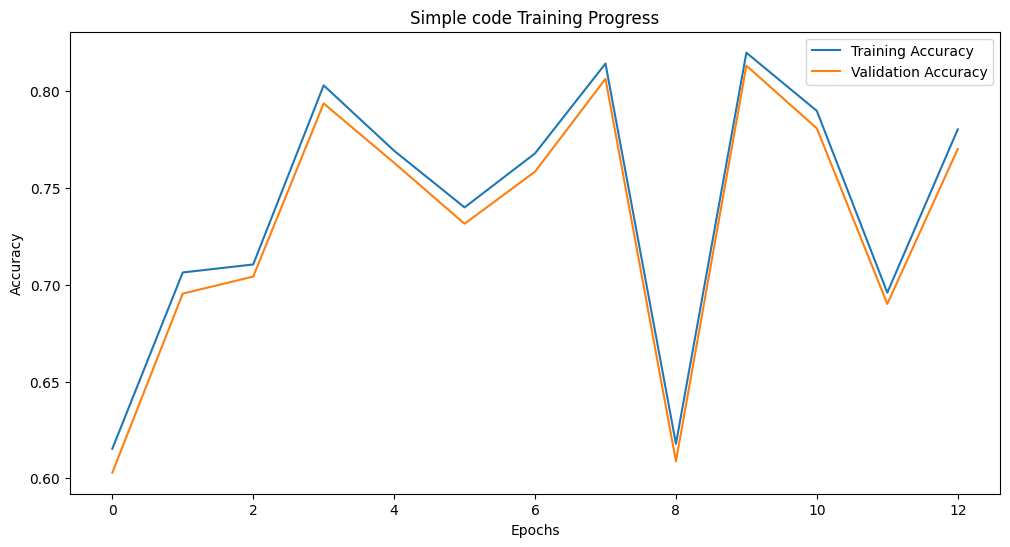

Accuracy: 0.7805435305435305
f1_score: 0.7252471521051839
простой_код


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 925.93ba/s]


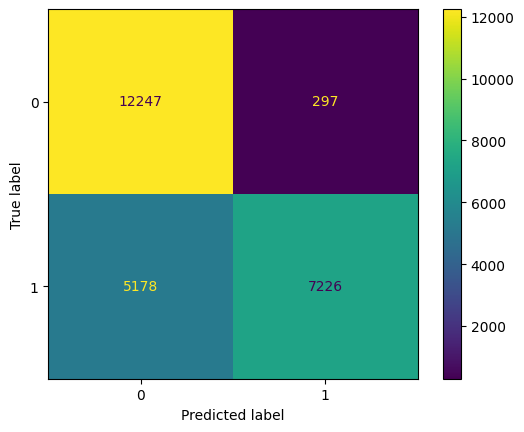

In [30]:
#классификационная голова с логированием

perceptron = Perceptron(tol=None, max_iter=1)

best_accuracy = 0
tol = 0.01
no_improvement = 0
max_no_improvement = 5

train_acc = []
val_acc = []

for epoch in range(1000):
    perceptron.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    y_pred_eval = perceptron.predict(X_eval)
    accuracy_eval = accuracy_score(y_eval, y_pred_eval)
    
    y_pred_train = perceptron.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    if accuracy_eval > best_accuracy + tol:
        best_accuracy = accuracy_eval
        no_improvement = 0
    else:
        no_improvement += 1
        
    train_acc.append(accuracy_train)
    val_acc.append(accuracy_eval)
    
    print('Epoch:', epoch+1, 'Validation Accuracy:', accuracy_eval)
    
    if no_improvement >= max_no_improvement:
        print('Early stopping triggered at epoch', epoch+1)
        break
    
    
title = "простой_код"
    
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Simple code Training Progress')
plt.legend()
plt.savefig('acc_график'+title+'prj.jpg')
plt.show()
    


y_pred = perceptron.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("простой_код_prediction.json")
plt.savefig('confusion_matrix_'+title+'prj.jpg')

Accuracy: 0.8286435786435786
f1_score: 0.8035476310831303
simple_code_EStop


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 892.89ba/s]


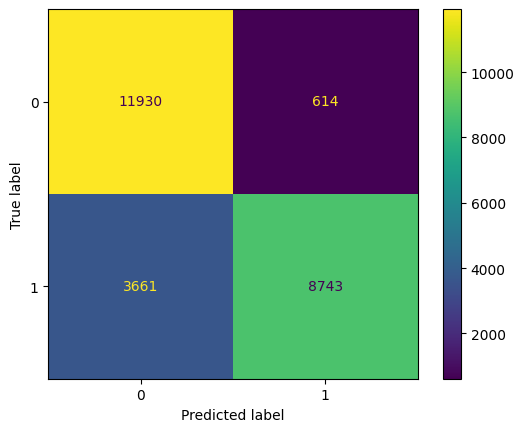

In [29]:
# классификационная голова без логирования с предостановкой

perceptron = Perceptron(early_stopping=True, tol=5, max_iter=1000)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()
title = "simple_code_EStop"
print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("simple_code_EStop_predicitons_2.json")
plt.savefig('confusion_matrix_'+title+'_2.jpg')


In [31]:
print(classification_report(y_test, y_pred, target_names=["не являются клонами", "являются клонами"]))

                     precision    recall  f1-score   support

не являются клонами       0.70      0.98      0.82     12544
   являются клонами       0.96      0.58      0.73     12404

           accuracy                           0.78     24948
          macro avg       0.83      0.78      0.77     24948
       weighted avg       0.83      0.78      0.77     24948

